# KNN-1: train with partial curves 

My idea is to used one of the partial cycle files to train the KNN model. For that, I need to get the distances between each of the partial curves with all the full curves. So for each partial curve, choose the closer full curve.
The result is an array with all the distances for each partial cycle. The number of cycle is the label of each distance.
With that i train the model.

Then, the user will give us a curve. We need to get first the distance of this curve to all our full curves and get the closer one.
That distance is what i feed the model to make a prediction of the cycle number.

We can used one file of partial curves as train set and then other as test set.

**I tried to do this, but the code for getting the distance for each partial curve takes FOREVER!. So i only used 2 partial curves to train. Of course this is not okey, but i just wanted to see if this made any sense**

In [48]:
import pandas as pd
import numpy as np
import import_data
import sort_data
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Load the data. We need full curves and one partial curve (that represents the user's curve)

PL03c,PL03d = sort_data.charge_discharge('converted_PL03.mat')
full_curvesc,full_curvesd = sort_data.charge_discharge('converted_PL11.mat')

PL10c,PL10d = sort_data.charge_discharge('data/converted_PL10.mat')

In [12]:
a = PL03d[444]['voltage'].values.flatten()
b = full_curvesd[2][['voltage']].values.flatten()

In [13]:
print(len(a),len(b))

801 693


In [100]:
#Make a shorter partial curve dictionary to uses as train set (because if not the code takes too long)
PL03d_short = {}
for idx in range(1, len(PL03d.keys()), 15):
        if idx in PL03d.keys():
            if idx not in PL03d_short.keys():
                PL03d_short[idx] = PL03d[idx]
PL03d_short.keys()        

dict_keys([1, 16, 31, 46, 61, 76, 91, 106, 121, 136, 151, 166, 181, 196, 211, 226, 241, 256, 271, 286, 301, 316, 331, 346, 361, 376, 391, 406, 421, 436, 451, 466, 481, 496, 511, 526, 541, 556, 571, 586, 601, 616, 646, 661, 676, 691, 811, 826, 841, 856, 871, 886, 901, 916, 931, 946, 961, 976, 991, 1006, 1021, 1036, 1051])

In [101]:
#Make a shorter partial curve dictionary to uses as train set (because if not the code takes too long)
full_curvesd_short = {}
for idx in range(1, len(full_curvesd.keys()), 15):
        if idx in full_curvesd.keys():
            if idx not in full_curvesd_short.keys():
                full_curvesd_short[idx] = full_curvesd[idx]
full_curvesd_short.keys()

dict_keys([1, 16, 31, 46, 61, 76, 91, 106, 121, 136, 151, 166, 181, 196, 211, 226, 241, 256, 271, 286, 301, 316, 331, 346, 361, 376, 391, 481, 496, 511, 526, 541, 556, 571, 586, 601, 616, 631, 646, 661, 676, 691, 706, 721, 736, 751, 766, 781, 796, 811, 826])

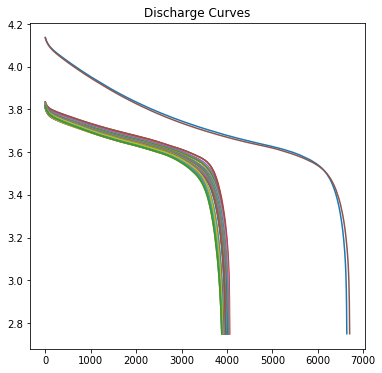

In [112]:
plt.figure(figsize = (6, 6))
for i in PL03d_short.keys():
    if i in PL03d_short.keys():
        plt.plot((PL03d_short[i]['time']-PL03d_short[i]['time'].iloc[0]), PL03d_short[i]['voltage'])
    else:
        pass
plt.title('Discharge Curves')
plt.show()

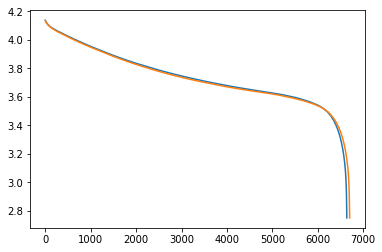

In [114]:
plt.plot((PL03d_short[1]['time']-PL03d_short[1]['time'].iloc[0]), PL03d_short[1]['voltage'])
plt.plot((PL03d_short[76]['time']-PL03d_short[76]['time'].iloc[0]), PL03d_short[76]['voltage'])

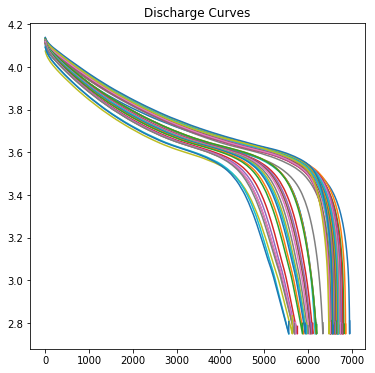

In [109]:
plt.figure(figsize = (6, 6))
for i in full_curvesd_short.keys():
    if i in full_curvesd_short.keys():
        plt.plot((full_curvesd_short[i]['time']-full_curvesd_short[i]['time'].iloc[0]), full_curvesd_short[i]['voltage'])
    else:
        pass
plt.title('Discharge Curves')
plt.show()

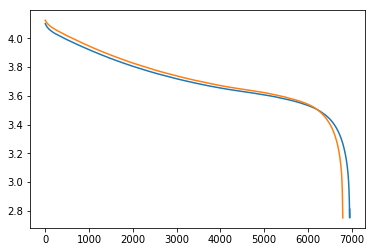

In [111]:
plt.plot((full_curvesd_short[1]['time']-full_curvesd_short[1]['time'].iloc[0]), full_curvesd_short[1]['voltage'])
plt.plot((full_curvesd_short[46]['time']-full_curvesd_short[46]['time'].iloc[0]), full_curvesd_short[46]['voltage'])

In [16]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def curve_distance(a,b):
#Inputs are two nparray    
    distance,path = fastdtw(a, b, dist=euclidean)
    return distance

Minor changes in this function (to give the DF instead of only the closest distance)

In [115]:
def distance_cycle_to_full(cycle,dic1,dic2):
#Inputs are 2 dictionaries and the number of cycle that is being tested
    if cycle not in dic1.keys():
        pass
    else:
        
        a = dic1[cycle][['voltage']].values.flatten()
        Y = []
    
        for idx in range(1,len(dic2.keys()) + 1):
            if idx in dic2.keys():
                b = dic2[idx][['voltage']].values.flatten()
                if len(b) > 100: #This is to mae sure the full curve has values (check curve 102, it has only 1 value) 
                    b = dic2[idx][['voltage']].values.flatten() 
                    d = curve_distance(a,b)
            
                    A = [idx,d]
                    Y.append(A)
                else:
                    pass
            else:
                pass
    df = pd.DataFrame(Y, columns = ['Cycle','Distance'])
    df = df.sort_values(by = ['Distance'])

    return df

Modify partial_to_full function (added a timer)

In [103]:
def partial_to_full(dic1,dic2):
    C = []
    D = []
    F = []
    
    for i in tqdm(dic1.keys()):
        df = distance_cycle_to_full2(i,dic1,dic2)
        Distance = df['Distance'][df.index[0]]
        Full_cycle = df['Cycle'][df.index[0]]
        C.append(i)
        D.append(Distance)
        F.append(Full_cycle)
       
    #For the model, we need the lists as NumPy arrays
    D = np.array(D)
    C = np.array(C)
    F = np.array(F)
    return D,C,F

In [18]:
len(PL03c_short.keys())

94

In [104]:
D, C, F = partial_to_full2(PL03d_short,full_curvesd_short)

HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

In [105]:
D

array([ 0.65470743, 20.83980155, 22.69731617, 22.15640783, 23.12662864,
        0.68590188, 23.21198988, 22.98252487, 24.17772603, 23.57292295,
       25.16069746, 21.1550858 , 20.44500732, 19.62477827, 19.66775298,
       19.6065011 , 21.05939031, 20.30801606, 20.67827868, 20.8735652 ,
       20.94955754, 21.35972118, 21.3481493 , 21.92794132, 21.17256141,
       21.22341251, 21.27455354, 20.2500062 , 20.8625772 , 20.94302559,
       21.4558084 , 20.63135386, 20.93184829, 21.22219825, 21.32976151,
       21.93548656, 21.96609664, 21.79120135, 22.18423629, 22.56851864,
       22.41466808, 22.49348354, 22.60066557, 23.86963964, 23.97691774,
       24.91642904, 23.51724815, 20.72663951, 23.78203845, 21.31874895,
       21.98519945, 22.07238317, 22.84684849, 22.09536266, 22.13064909,
       22.35662103, 21.67383146, 22.0275414 , 22.23128533, 22.47685218,
       22.70252323, 22.81567073, 22.87166643])

In [106]:
F

array([46,  1,  1,  1,  1, 46,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
distance_cycle_to_full(1,PL03c_short,full_curvesc_short)

In [ ]:
distance_cycle_to_full(11,PL03c_short,full_curvesc_short)

Train the model:

In [80]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(D.reshape(-1, 1), C) #Train the classifier with the distance and the corresponding cycles

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [37]:
#For predicting first we need the distance between the testing curve to the full curves
def distance_to_full(curve,dic):
 
    #Convert the data in the data frame to a NumPy array
    a = curve.values.flatten() 
    Y = []
    
    #Calculate the distances between the testing curve and each of the full curve cycle
    for i in range(1,len(dic.keys()) + 1):
        if i in dic.keys():
            b = dic[i][['voltage']].values.flatten()
            if len(b) > 100: #This is to mae sure the full curve has values (check curve 102, it has only 1 value)
                d = curve_distance(a,b)
            
                A = [i,d]
                Y.append(A)
            else:
                pass
        else:
            pass
    #Creat a Pandas dataframe with the distances for each cycle. Sort the data frame by distance
    df = pd.DataFrame(Y, columns = ['Cycle','Distance'])
    df = df.sort_values(by = ['Distance'])
    return df

In [81]:
df = distance_to_full(PL03d[700]['voltage'],full_curvesd_short)
df

,Cycle,Distance
0,1,24.917708
1,6,26.921217
2,11,27.820870
3,16,28.738848
6,31,28.820830
5,26,29.080979
4,21,29.147005
7,36,29.549812
8,41,30.155359
14,71,30.214310


In [82]:
Dist = df['Distance'][df.index[0]]
Dist

24.91770839691162

In [83]:
neigh.predict(Dist)

array([691])

In [94]:
df = distance_to_full(PL03d[72]['voltage'],full_curvesd_short)

In [95]:
Dist = df['Distance'][df.index[0]]
Dist

23.209219455718994

In [96]:
neigh.predict(Dist)

array([91])

In [99]:
df = distance_to_full(PL03d[10]['voltage'],full_curvesd_short)
Dist = df['Distance'][df.index[0]]
neigh.predict(Dist)

array([576])

In [87]:
df = distance_to_full(PL03d[350]['voltage'],full_curvesd_short)

In [66]:
Dist = df['Distance'][df.index[0]]
Dist

21.960790395736694

In [67]:
neigh.predict(Dist)

array([351])

In [68]:
df = distance_to_full(PL03d[400]['voltage'],full_curvesd_short)

In [69]:
Dist = df['Distance'][df.index[0]]
Dist

21.62289333343506

In [70]:
neigh.predict(Dist)

array([401])

In [71]:
df = distance_to_full(PL03d[600]['voltage'],full_curvesd_short)

In [72]:
Dist = df['Distance'][df.index[0]]
Dist

22.471768617630005

In [73]:
neigh.predict(Dist)

array([611])